In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Monet images: 260
Photo images: 7038


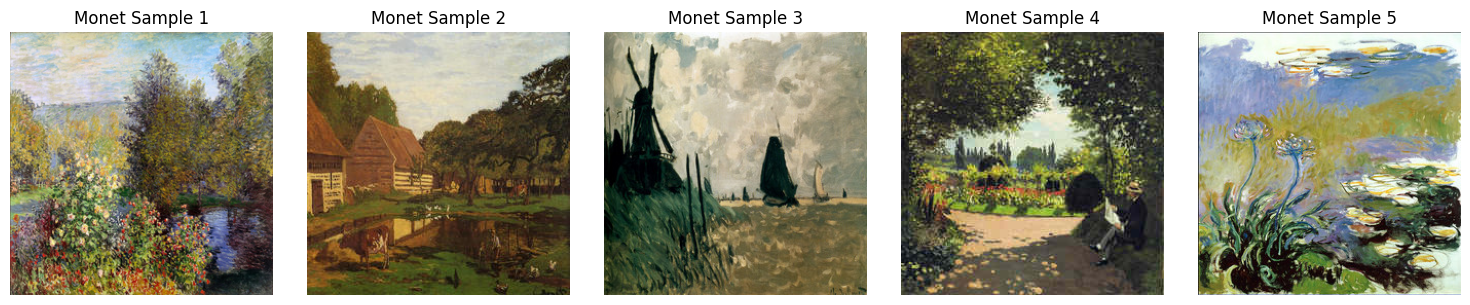

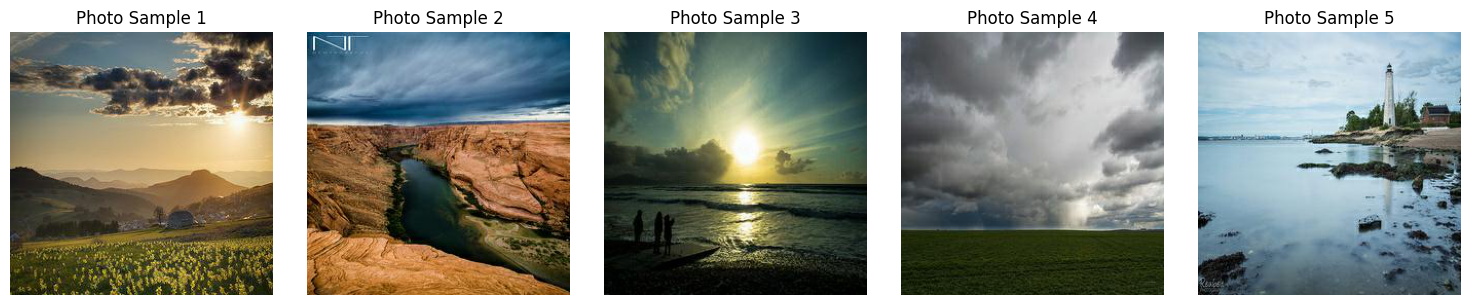

In [2]:
# Step 1: Define paths and print 5 sample images from each
base_path = "data-266-competition-gan-image-style-transfer/competition_data"
monet_path = os.path.join(base_path, "monet_jpg")
photo_path = os.path.join(base_path, "photo_jpg")

# Get list of files
monet_files = os.listdir(monet_path)
photo_files = os.listdir(photo_path)

# Print counts
print(f"Monet images: {len(monet_files)}")
print(f"Photo images: {len(photo_files)}")

# Function to display sample images
def show_sample_images(folder_path, title_prefix, num_samples=5):
    sample_files = sorted(os.listdir(folder_path))[:num_samples]  # Sort for consistency
    plt.figure(figsize=(15, 3))
    for i, file in enumerate(sample_files):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path)  # Load image with PIL
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)  # Display image
        plt.title(f"{title_prefix} {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show samples
show_sample_images(monet_path, "Monet Sample")
show_sample_images(photo_path, "Photo Sample")

In [3]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),         # Resize to 256x256 as per competition rules
    transforms.ToTensor(),                 # Convert PIL image to PyTorch tensor [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')  # Ensure RGB format
        if self.transform:
            img = self.transform(img)
        return img

# Create datasets and loaders
monet_dataset = ImageDataset(monet_path, transform=transform)
photo_dataset = ImageDataset(photo_path, transform=transform)
monet_loader = DataLoader(monet_dataset, batch_size=1, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=1, shuffle=True)

# Test the loader (optional)
for i, batch in enumerate(monet_loader):
    print(f"Batch {i} shape: {batch.shape}")
    if i == 2:  # Print first 3 batches
        break

Batch 0 shape: torch.Size([1, 3, 256, 256])
Batch 1 shape: torch.Size([1, 3, 256, 256])
Batch 2 shape: torch.Size([1, 3, 256, 256])


In [4]:
### Defining Cyclic GAN
import torch.optim as optim
import torch.nn as nn

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Residual Block for Generator
class ResBlock(nn.Module):
    def __init__(self, dim):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1, padding_mode='reflect'),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 3, 1, 1, padding_mode='reflect'),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

# Generator with 9 Residual Blocks
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 7, 1, 3, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.res_blocks = nn.Sequential(*[ResBlock(256) for _ in range(9)])  # 9 residual blocks
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 7, 1, 3, padding_mode='reflect'),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

# Discriminator with 4-layer PatchGAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),           # Layer 1
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),         # Layer 2
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),        # Layer 3
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 1, 1),        # Layer 4
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 1)           # Output layer (no sigmoid for MSE loss)
        )
    def forward(self, x):
        return self.main(x)
# Re-instantiate models
G_photo_to_monet = Generator().to(device)
G_monet_to_photo = Generator().to(device)
D_monet = Discriminator().to(device)
D_photo = Discriminator().to(device)

In [5]:
## Defining Losses

import torch.nn as nn

# Loss functions
adversarial_loss = nn.MSELoss()  # MSE for discriminator
cycle_loss = nn.L1Loss()         # L1 loss for cycle-consistency

# Labels for real and fake
real_label = torch.ones((1, 1, 30, 30))  # Adjust size based on discriminator output
fake_label = torch.zeros((1, 1, 30, 30)) # Same size as real_label


In [6]:
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

# Optimizers
optim_G = optim.Adam(list(G_photo_to_monet.parameters()) + list(G_monet_to_photo.parameters()), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(list(D_monet.parameters()) + list(D_photo.parameters()), lr=0.0002, betas=(0.5, 0.999))

# Learning rate scheduler (decay after 100 epochs)
lr_lambda = lambda epoch: 1.0 if epoch < 100 else 1.0 - max(0, epoch - 100) / 100
scheduler_G = LambdaLR(optim_G, lr_lambda)
scheduler_D = LambdaLR(optim_D, lr_lambda)

# Training loop
num_epochs = 200  # Increased for better FID
lambda_cycle = 10.0

output_dir = "generated_monet_images"  # Consistent with submission naming
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    # Variables to accumulate losses over the epoch
    total_loss_D = 0.0
    total_loss_G = 0.0
    num_batches = 0

    # Training loop with progress bar
    data_iter = zip(photo_loader, monet_loader)
    with tqdm(data_iter, total=min(len(photo_loader), len(monet_loader)), desc=f"Epoch [{epoch+1}/{num_epochs}]") as pbar:
        for i, (photo, monet) in enumerate(pbar):
            photo, monet = photo.to(device), monet.to(device)

            # --- Train Discriminators ---
            optim_D.zero_grad()
            real_monet_pred = D_monet(monet)
            loss_D_monet_real = adversarial_loss(real_monet_pred, torch.ones_like(real_monet_pred))
            real_photo_pred = D_photo(photo)
            loss_D_photo_real = adversarial_loss(real_photo_pred, torch.ones_like(real_photo_pred))
            fake_monet = G_photo_to_monet(photo)
            fake_monet_pred = D_monet(fake_monet.detach())
            loss_D_monet_fake = adversarial_loss(fake_monet_pred, torch.zeros_like(fake_monet_pred))
            fake_photo = G_monet_to_photo(monet)
            fake_photo_pred = D_photo(fake_photo.detach())
            loss_D_photo_fake = adversarial_loss(fake_photo_pred, torch.zeros_like(fake_photo_pred))
            loss_D = (loss_D_monet_real + loss_D_monet_fake + loss_D_photo_real + loss_D_photo_fake) * 0.5
            loss_D.backward()
            optim_D.step()

            # --- Train Generators ---
            optim_G.zero_grad()
            fake_monet_pred = D_monet(fake_monet)
            loss_G_monet = adversarial_loss(fake_monet_pred, torch.ones_like(fake_monet_pred))
            fake_photo_pred = D_photo(fake_photo)
            loss_G_photo = adversarial_loss(fake_photo_pred, torch.ones_like(fake_photo_pred))
            recovered_photo = G_monet_to_photo(fake_monet)
            loss_cycle_photo = cycle_loss(recovered_photo, photo)
            recovered_monet = G_photo_to_monet(fake_photo)
            loss_cycle_monet = cycle_loss(recovered_monet, monet)
            loss_G = loss_G_monet + loss_G_photo + lambda_cycle * (loss_cycle_photo + loss_cycle_monet)
            loss_G.backward()
            optim_G.step()

            # Accumulate losses
            total_loss_D += loss_D.item()
            total_loss_G += loss_G.item()
            num_batches += 1

            # Update progress bar with current losses
            pbar.set_postfix({'Loss D': f'{loss_D.item():.4f}', 'Loss G': f'{loss_G.item():.4f}'})

    # Print average losses for the epoch
    avg_loss_D = total_loss_D / num_batches
    avg_loss_G = total_loss_G / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss D: {avg_loss_D:.4f}, Avg Loss G: {avg_loss_G:.4f}")

    # Update learning rate
    scheduler_G.step()
    scheduler_D.step()

    
    if (epoch + 1) % 50 == 0:
        torch.save(G_photo_to_monet.state_dict(), f"G_photo_to_monet_epoch_{epoch+1}.pth")

    

Epoch [1/200]: 100%|██████████| 260/260 [00:19<00:00, 13.51it/s, Loss D=0.5289, Loss G=5.6949] 


Epoch [1/200] Avg Loss D: 0.5637, Avg Loss G: 7.2079


Epoch [2/200]: 100%|██████████| 260/260 [00:19<00:00, 13.14it/s, Loss D=0.6987, Loss G=5.6705] 


Epoch [2/200] Avg Loss D: 0.4770, Avg Loss G: 6.7543


Epoch [3/200]: 100%|██████████| 260/260 [00:19<00:00, 13.10it/s, Loss D=0.4964, Loss G=9.3445] 


Epoch [3/200] Avg Loss D: 0.4290, Avg Loss G: 6.8850


Epoch [4/200]: 100%|██████████| 260/260 [00:19<00:00, 13.02it/s, Loss D=0.4094, Loss G=7.3057] 


Epoch [4/200] Avg Loss D: 0.4247, Avg Loss G: 6.9078


Epoch [5/200]: 100%|██████████| 260/260 [00:20<00:00, 12.90it/s, Loss D=0.4987, Loss G=6.7735] 


Epoch [5/200] Avg Loss D: 0.4017, Avg Loss G: 6.9570


Epoch [6/200]: 100%|██████████| 260/260 [00:19<00:00, 13.13it/s, Loss D=0.6314, Loss G=4.9838] 


Epoch [6/200] Avg Loss D: 0.4136, Avg Loss G: 6.9399


Epoch [7/200]: 100%|██████████| 260/260 [00:20<00:00, 12.99it/s, Loss D=0.4982, Loss G=6.0159] 


Epoch [7/200] Avg Loss D: 0.4135, Avg Loss G: 6.5742


Epoch [8/200]: 100%|██████████| 260/260 [00:19<00:00, 13.22it/s, Loss D=0.3205, Loss G=5.0976] 


Epoch [8/200] Avg Loss D: 0.4044, Avg Loss G: 6.3552


Epoch [9/200]: 100%|██████████| 260/260 [00:19<00:00, 13.26it/s, Loss D=0.3864, Loss G=5.3263] 


Epoch [9/200] Avg Loss D: 0.4007, Avg Loss G: 6.2856


Epoch [10/200]: 100%|██████████| 260/260 [00:19<00:00, 13.14it/s, Loss D=0.4432, Loss G=5.7221] 


Epoch [10/200] Avg Loss D: 0.4001, Avg Loss G: 6.4106


Epoch [11/200]: 100%|██████████| 260/260 [00:19<00:00, 13.20it/s, Loss D=0.4647, Loss G=4.7704] 


Epoch [11/200] Avg Loss D: 0.3888, Avg Loss G: 6.0647


Epoch [12/200]: 100%|██████████| 260/260 [00:19<00:00, 13.30it/s, Loss D=0.4595, Loss G=4.3367] 


Epoch [12/200] Avg Loss D: 0.3715, Avg Loss G: 6.2576


Epoch [13/200]: 100%|██████████| 260/260 [00:19<00:00, 13.21it/s, Loss D=0.3862, Loss G=6.8532] 


Epoch [13/200] Avg Loss D: 0.3853, Avg Loss G: 6.0218


Epoch [14/200]: 100%|██████████| 260/260 [00:19<00:00, 13.12it/s, Loss D=0.4127, Loss G=4.3440]


Epoch [14/200] Avg Loss D: 0.3778, Avg Loss G: 5.9785


Epoch [15/200]: 100%|██████████| 260/260 [00:19<00:00, 13.04it/s, Loss D=0.1925, Loss G=6.2150] 


Epoch [15/200] Avg Loss D: 0.3650, Avg Loss G: 6.0162


Epoch [16/200]: 100%|██████████| 260/260 [00:20<00:00, 12.47it/s, Loss D=0.6388, Loss G=4.5268] 


Epoch [16/200] Avg Loss D: 0.3525, Avg Loss G: 6.0343


Epoch [17/200]: 100%|██████████| 260/260 [00:20<00:00, 12.52it/s, Loss D=0.4852, Loss G=7.4073] 


Epoch [17/200] Avg Loss D: 0.3577, Avg Loss G: 5.9129


Epoch [18/200]: 100%|██████████| 260/260 [00:19<00:00, 13.21it/s, Loss D=0.5027, Loss G=5.4692] 


Epoch [18/200] Avg Loss D: 0.3591, Avg Loss G: 5.8020


Epoch [19/200]: 100%|██████████| 260/260 [00:19<00:00, 13.00it/s, Loss D=0.3975, Loss G=5.4138]


Epoch [19/200] Avg Loss D: 0.3331, Avg Loss G: 5.8573


Epoch [20/200]: 100%|██████████| 260/260 [00:19<00:00, 13.56it/s, Loss D=0.4922, Loss G=5.0466] 


Epoch [20/200] Avg Loss D: 0.3196, Avg Loss G: 6.0526


Epoch [21/200]: 100%|██████████| 260/260 [00:19<00:00, 13.33it/s, Loss D=0.2371, Loss G=5.5869] 


Epoch [21/200] Avg Loss D: 0.3095, Avg Loss G: 5.9369


Epoch [22/200]: 100%|██████████| 260/260 [00:19<00:00, 13.44it/s, Loss D=0.2614, Loss G=7.3618]


Epoch [22/200] Avg Loss D: 0.3002, Avg Loss G: 5.9799


Epoch [23/200]: 100%|██████████| 260/260 [00:19<00:00, 13.14it/s, Loss D=0.4493, Loss G=4.5453] 


Epoch [23/200] Avg Loss D: 0.3133, Avg Loss G: 5.9751


Epoch [24/200]: 100%|██████████| 260/260 [00:20<00:00, 12.71it/s, Loss D=0.2156, Loss G=5.4948] 


Epoch [24/200] Avg Loss D: 0.3017, Avg Loss G: 5.8946


Epoch [25/200]: 100%|██████████| 260/260 [00:19<00:00, 13.02it/s, Loss D=0.1089, Loss G=5.7358]


Epoch [25/200] Avg Loss D: 0.2861, Avg Loss G: 6.0230


Epoch [26/200]: 100%|██████████| 260/260 [00:19<00:00, 13.11it/s, Loss D=0.1809, Loss G=6.3177] 


Epoch [26/200] Avg Loss D: 0.2939, Avg Loss G: 5.8844


Epoch [27/200]: 100%|██████████| 260/260 [00:19<00:00, 13.40it/s, Loss D=0.3684, Loss G=4.4105]


Epoch [27/200] Avg Loss D: 0.2846, Avg Loss G: 5.8596


Epoch [28/200]: 100%|██████████| 260/260 [00:19<00:00, 13.31it/s, Loss D=0.1462, Loss G=5.3281] 


Epoch [28/200] Avg Loss D: 0.2707, Avg Loss G: 5.9162


Epoch [29/200]: 100%|██████████| 260/260 [00:19<00:00, 13.28it/s, Loss D=0.2163, Loss G=5.2593] 


Epoch [29/200] Avg Loss D: 0.2357, Avg Loss G: 6.0024


Epoch [30/200]: 100%|██████████| 260/260 [00:18<00:00, 13.70it/s, Loss D=0.2126, Loss G=5.3084]


Epoch [30/200] Avg Loss D: 0.2270, Avg Loss G: 5.9638


Epoch [31/200]: 100%|██████████| 260/260 [00:19<00:00, 13.44it/s, Loss D=0.0580, Loss G=4.8349]


Epoch [31/200] Avg Loss D: 0.2383, Avg Loss G: 5.9819


Epoch [32/200]: 100%|██████████| 260/260 [00:20<00:00, 12.76it/s, Loss D=0.1359, Loss G=5.4294]


Epoch [32/200] Avg Loss D: 0.2183, Avg Loss G: 5.9897


Epoch [33/200]: 100%|██████████| 260/260 [00:20<00:00, 12.78it/s, Loss D=0.2386, Loss G=6.5248] 


Epoch [33/200] Avg Loss D: 0.2305, Avg Loss G: 5.8711


Epoch [34/200]: 100%|██████████| 260/260 [00:19<00:00, 13.24it/s, Loss D=0.2471, Loss G=5.8936] 


Epoch [34/200] Avg Loss D: 0.2600, Avg Loss G: 5.8650


Epoch [35/200]: 100%|██████████| 260/260 [00:19<00:00, 13.30it/s, Loss D=0.2299, Loss G=4.8153]


Epoch [35/200] Avg Loss D: 0.2520, Avg Loss G: 5.7063


Epoch [36/200]: 100%|██████████| 260/260 [00:19<00:00, 13.36it/s, Loss D=0.1376, Loss G=5.8144]


Epoch [36/200] Avg Loss D: 0.2654, Avg Loss G: 5.7627


Epoch [37/200]: 100%|██████████| 260/260 [00:20<00:00, 12.79it/s, Loss D=0.5556, Loss G=5.1175]


Epoch [37/200] Avg Loss D: 0.2771, Avg Loss G: 5.7444


Epoch [38/200]: 100%|██████████| 260/260 [00:20<00:00, 12.56it/s, Loss D=0.0586, Loss G=6.4865]


Epoch [38/200] Avg Loss D: 0.2527, Avg Loss G: 5.8913


Epoch [39/200]: 100%|██████████| 260/260 [00:20<00:00, 12.79it/s, Loss D=0.2570, Loss G=6.8893]


Epoch [39/200] Avg Loss D: 0.2375, Avg Loss G: 5.7768


Epoch [40/200]: 100%|██████████| 260/260 [00:19<00:00, 13.19it/s, Loss D=0.1556, Loss G=6.3254]


Epoch [40/200] Avg Loss D: 0.2577, Avg Loss G: 5.7097


Epoch [41/200]: 100%|██████████| 260/260 [00:19<00:00, 13.36it/s, Loss D=0.3149, Loss G=7.6363]


Epoch [41/200] Avg Loss D: 0.2734, Avg Loss G: 5.6672


Epoch [42/200]: 100%|██████████| 260/260 [00:19<00:00, 13.44it/s, Loss D=0.2301, Loss G=5.6482]


Epoch [42/200] Avg Loss D: 0.2836, Avg Loss G: 5.5509


Epoch [43/200]: 100%|██████████| 260/260 [00:19<00:00, 13.45it/s, Loss D=0.2538, Loss G=4.5521]


Epoch [43/200] Avg Loss D: 0.2795, Avg Loss G: 5.6935


Epoch [44/200]: 100%|██████████| 260/260 [00:19<00:00, 13.47it/s, Loss D=0.1316, Loss G=6.3418]


Epoch [44/200] Avg Loss D: 0.2783, Avg Loss G: 5.5841


Epoch [45/200]: 100%|██████████| 260/260 [00:19<00:00, 13.09it/s, Loss D=0.1956, Loss G=5.9830]


Epoch [45/200] Avg Loss D: 0.2748, Avg Loss G: 5.5001


Epoch [46/200]: 100%|██████████| 260/260 [00:19<00:00, 13.51it/s, Loss D=0.3094, Loss G=5.3864]


Epoch [46/200] Avg Loss D: 0.2853, Avg Loss G: 5.4838


Epoch [47/200]: 100%|██████████| 260/260 [00:20<00:00, 13.00it/s, Loss D=0.2658, Loss G=4.5807]


Epoch [47/200] Avg Loss D: 0.2797, Avg Loss G: 5.4361


Epoch [48/200]: 100%|██████████| 260/260 [00:19<00:00, 13.07it/s, Loss D=0.3211, Loss G=8.0527]


Epoch [48/200] Avg Loss D: 0.2560, Avg Loss G: 5.6535


Epoch [49/200]: 100%|██████████| 260/260 [00:19<00:00, 13.25it/s, Loss D=0.4454, Loss G=6.3120]


Epoch [49/200] Avg Loss D: 0.2517, Avg Loss G: 5.5447


Epoch [50/200]: 100%|██████████| 260/260 [00:19<00:00, 13.01it/s, Loss D=0.1590, Loss G=7.4297]


Epoch [50/200] Avg Loss D: 0.2534, Avg Loss G: 5.5978


Epoch [51/200]: 100%|██████████| 260/260 [00:19<00:00, 13.32it/s, Loss D=0.2505, Loss G=6.1146]


Epoch [51/200] Avg Loss D: 0.2128, Avg Loss G: 5.7760


Epoch [52/200]: 100%|██████████| 260/260 [00:19<00:00, 13.42it/s, Loss D=0.2791, Loss G=4.5431]


Epoch [52/200] Avg Loss D: 0.2436, Avg Loss G: 5.6582


Epoch [53/200]: 100%|██████████| 260/260 [00:19<00:00, 13.43it/s, Loss D=0.1252, Loss G=6.5353]


Epoch [53/200] Avg Loss D: 0.2198, Avg Loss G: 5.6825


Epoch [54/200]: 100%|██████████| 260/260 [00:19<00:00, 13.43it/s, Loss D=0.2722, Loss G=4.6131] 


Epoch [54/200] Avg Loss D: 0.2063, Avg Loss G: 5.8410


Epoch [55/200]: 100%|██████████| 260/260 [00:19<00:00, 13.42it/s, Loss D=0.3796, Loss G=6.6904]


Epoch [55/200] Avg Loss D: 0.2243, Avg Loss G: 5.6198


Epoch [56/200]: 100%|██████████| 260/260 [00:19<00:00, 13.40it/s, Loss D=0.2007, Loss G=4.9425] 


Epoch [56/200] Avg Loss D: 0.2295, Avg Loss G: 5.5367


Epoch [57/200]: 100%|██████████| 260/260 [00:19<00:00, 13.48it/s, Loss D=0.1585, Loss G=6.0469]


Epoch [57/200] Avg Loss D: 0.2214, Avg Loss G: 5.6305


Epoch [58/200]: 100%|██████████| 260/260 [00:19<00:00, 13.36it/s, Loss D=0.1248, Loss G=6.0104]


Epoch [58/200] Avg Loss D: 0.2311, Avg Loss G: 5.4760


Epoch [59/200]: 100%|██████████| 260/260 [00:19<00:00, 13.49it/s, Loss D=0.1933, Loss G=5.6530]


Epoch [59/200] Avg Loss D: 0.2291, Avg Loss G: 5.4684


Epoch [60/200]: 100%|██████████| 260/260 [00:19<00:00, 13.32it/s, Loss D=0.2214, Loss G=5.0034]


Epoch [60/200] Avg Loss D: 0.2399, Avg Loss G: 5.4933


Epoch [61/200]: 100%|██████████| 260/260 [00:19<00:00, 13.39it/s, Loss D=0.3461, Loss G=4.7623]


Epoch [61/200] Avg Loss D: 0.2293, Avg Loss G: 5.3578


Epoch [62/200]: 100%|██████████| 260/260 [00:19<00:00, 13.41it/s, Loss D=0.1199, Loss G=7.8546] 


Epoch [62/200] Avg Loss D: 0.2402, Avg Loss G: 5.3933


Epoch [63/200]: 100%|██████████| 260/260 [00:19<00:00, 13.05it/s, Loss D=0.2107, Loss G=6.3099]


Epoch [63/200] Avg Loss D: 0.2428, Avg Loss G: 5.4825


Epoch [64/200]: 100%|██████████| 260/260 [00:18<00:00, 13.72it/s, Loss D=0.4275, Loss G=4.0358]


Epoch [64/200] Avg Loss D: 0.2449, Avg Loss G: 5.3888


Epoch [65/200]: 100%|██████████| 260/260 [00:19<00:00, 13.14it/s, Loss D=0.1545, Loss G=5.2663]


Epoch [65/200] Avg Loss D: 0.2371, Avg Loss G: 5.4071


Epoch [66/200]: 100%|██████████| 260/260 [00:20<00:00, 12.91it/s, Loss D=0.2945, Loss G=4.4576]


Epoch [66/200] Avg Loss D: 0.2283, Avg Loss G: 5.3085


Epoch [67/200]: 100%|██████████| 260/260 [00:19<00:00, 13.08it/s, Loss D=0.2402, Loss G=4.2038]


Epoch [67/200] Avg Loss D: 0.2402, Avg Loss G: 5.3232


Epoch [68/200]: 100%|██████████| 260/260 [00:19<00:00, 13.07it/s, Loss D=0.2183, Loss G=6.0347]


Epoch [68/200] Avg Loss D: 0.2272, Avg Loss G: 5.3069


Epoch [69/200]: 100%|██████████| 260/260 [00:19<00:00, 13.46it/s, Loss D=0.0831, Loss G=8.0134]


Epoch [69/200] Avg Loss D: 0.2374, Avg Loss G: 5.3792


Epoch [70/200]: 100%|██████████| 260/260 [00:19<00:00, 13.41it/s, Loss D=0.0999, Loss G=6.0096]


Epoch [70/200] Avg Loss D: 0.2369, Avg Loss G: 5.2975


Epoch [71/200]: 100%|██████████| 260/260 [00:19<00:00, 13.40it/s, Loss D=0.4040, Loss G=6.7957]


Epoch [71/200] Avg Loss D: 0.2291, Avg Loss G: 5.3336


Epoch [72/200]: 100%|██████████| 260/260 [00:19<00:00, 13.14it/s, Loss D=0.2277, Loss G=4.9992]


Epoch [72/200] Avg Loss D: 0.2289, Avg Loss G: 5.3555


Epoch [73/200]: 100%|██████████| 260/260 [00:19<00:00, 13.16it/s, Loss D=0.2522, Loss G=4.7963]  


Epoch [73/200] Avg Loss D: 0.6754, Avg Loss G: 5.4630


Epoch [74/200]: 100%|██████████| 260/260 [00:19<00:00, 13.36it/s, Loss D=0.3336, Loss G=5.3619]


Epoch [74/200] Avg Loss D: 0.3512, Avg Loss G: 4.5835


Epoch [75/200]: 100%|██████████| 260/260 [00:19<00:00, 13.24it/s, Loss D=0.3022, Loss G=4.2325]


Epoch [75/200] Avg Loss D: 0.3398, Avg Loss G: 4.5329


Epoch [76/200]: 100%|██████████| 260/260 [00:19<00:00, 13.06it/s, Loss D=0.3515, Loss G=4.7409]


Epoch [76/200] Avg Loss D: 0.2879, Avg Loss G: 4.6473


Epoch [77/200]: 100%|██████████| 260/260 [00:19<00:00, 13.03it/s, Loss D=0.2474, Loss G=4.9029]


Epoch [77/200] Avg Loss D: 0.2776, Avg Loss G: 4.8107


Epoch [78/200]: 100%|██████████| 260/260 [00:19<00:00, 13.37it/s, Loss D=0.3291, Loss G=4.6676]


Epoch [78/200] Avg Loss D: 0.2640, Avg Loss G: 4.7829


Epoch [79/200]: 100%|██████████| 260/260 [00:19<00:00, 13.23it/s, Loss D=0.2069, Loss G=4.5074]


Epoch [79/200] Avg Loss D: 0.2725, Avg Loss G: 4.8995


Epoch [80/200]: 100%|██████████| 260/260 [00:20<00:00, 12.89it/s, Loss D=0.1381, Loss G=4.5859]


Epoch [80/200] Avg Loss D: 0.2697, Avg Loss G: 5.0833


Epoch [81/200]: 100%|██████████| 260/260 [00:19<00:00, 13.51it/s, Loss D=0.1760, Loss G=5.1009]


Epoch [81/200] Avg Loss D: 0.2288, Avg Loss G: 5.1368


Epoch [82/200]: 100%|██████████| 260/260 [00:19<00:00, 13.06it/s, Loss D=0.2631, Loss G=3.9840]


Epoch [82/200] Avg Loss D: 0.2195, Avg Loss G: 5.0743


Epoch [83/200]: 100%|██████████| 260/260 [00:20<00:00, 12.88it/s, Loss D=0.2488, Loss G=4.1272]


Epoch [83/200] Avg Loss D: 0.2132, Avg Loss G: 5.1897


Epoch [84/200]: 100%|██████████| 260/260 [00:19<00:00, 13.47it/s, Loss D=0.1424, Loss G=4.7358]


Epoch [84/200] Avg Loss D: 0.2320, Avg Loss G: 5.1363


Epoch [85/200]: 100%|██████████| 260/260 [00:19<00:00, 13.40it/s, Loss D=0.1116, Loss G=5.9252]


Epoch [85/200] Avg Loss D: 0.2462, Avg Loss G: 5.0944


Epoch [86/200]: 100%|██████████| 260/260 [00:19<00:00, 13.68it/s, Loss D=0.1062, Loss G=6.1370]


Epoch [86/200] Avg Loss D: 0.2363, Avg Loss G: 5.0782


Epoch [87/200]: 100%|██████████| 260/260 [00:18<00:00, 13.72it/s, Loss D=0.1362, Loss G=5.4192]


Epoch [87/200] Avg Loss D: 0.2440, Avg Loss G: 5.1169


Epoch [88/200]: 100%|██████████| 260/260 [00:18<00:00, 13.76it/s, Loss D=0.3121, Loss G=6.1035]


Epoch [88/200] Avg Loss D: 0.2267, Avg Loss G: 5.1057


Epoch [89/200]: 100%|██████████| 260/260 [00:18<00:00, 13.75it/s, Loss D=0.3040, Loss G=4.3410]


Epoch [89/200] Avg Loss D: 0.2124, Avg Loss G: 5.2584


Epoch [90/200]: 100%|██████████| 260/260 [00:19<00:00, 13.47it/s, Loss D=0.3979, Loss G=4.3862]


Epoch [90/200] Avg Loss D: 0.2315, Avg Loss G: 5.0987


Epoch [91/200]: 100%|██████████| 260/260 [00:19<00:00, 13.50it/s, Loss D=0.1589, Loss G=4.1405]


Epoch [91/200] Avg Loss D: 0.2209, Avg Loss G: 5.0706


Epoch [92/200]: 100%|██████████| 260/260 [00:19<00:00, 13.42it/s, Loss D=0.5372, Loss G=4.7948] 


Epoch [92/200] Avg Loss D: 0.2231, Avg Loss G: 5.0965


Epoch [93/200]: 100%|██████████| 260/260 [00:19<00:00, 13.05it/s, Loss D=0.0629, Loss G=5.9512]


Epoch [93/200] Avg Loss D: 0.2227, Avg Loss G: 5.0851


Epoch [94/200]: 100%|██████████| 260/260 [00:19<00:00, 13.33it/s, Loss D=0.1606, Loss G=4.7317]


Epoch [94/200] Avg Loss D: 0.2370, Avg Loss G: 5.1337


Epoch [95/200]: 100%|██████████| 260/260 [00:19<00:00, 13.39it/s, Loss D=0.1546, Loss G=4.8420] 


Epoch [95/200] Avg Loss D: 0.2051, Avg Loss G: 5.1640


Epoch [96/200]: 100%|██████████| 260/260 [00:19<00:00, 13.10it/s, Loss D=0.1113, Loss G=9.2948]


Epoch [96/200] Avg Loss D: 0.2128, Avg Loss G: 5.1193


Epoch [97/200]: 100%|██████████| 260/260 [00:19<00:00, 13.40it/s, Loss D=0.1421, Loss G=5.1716]


Epoch [97/200] Avg Loss D: 0.2281, Avg Loss G: 4.9072


Epoch [98/200]: 100%|██████████| 260/260 [00:19<00:00, 13.37it/s, Loss D=0.0978, Loss G=4.2980]


Epoch [98/200] Avg Loss D: 0.2034, Avg Loss G: 5.0916


Epoch [99/200]: 100%|██████████| 260/260 [00:19<00:00, 13.09it/s, Loss D=0.2431, Loss G=4.5964]


Epoch [99/200] Avg Loss D: 0.2063, Avg Loss G: 5.1176


Epoch [100/200]: 100%|██████████| 260/260 [00:21<00:00, 12.13it/s, Loss D=0.2330, Loss G=5.0691]


Epoch [100/200] Avg Loss D: 0.1991, Avg Loss G: 5.1462


Epoch [101/200]: 100%|██████████| 260/260 [00:19<00:00, 13.07it/s, Loss D=0.1989, Loss G=5.5190]


Epoch [101/200] Avg Loss D: 0.1833, Avg Loss G: 5.1062


Epoch [102/200]: 100%|██████████| 260/260 [00:19<00:00, 13.67it/s, Loss D=0.1326, Loss G=5.4822] 


Epoch [102/200] Avg Loss D: 0.1897, Avg Loss G: 5.2803


Epoch [103/200]: 100%|██████████| 260/260 [00:19<00:00, 13.63it/s, Loss D=0.0733, Loss G=4.9410]


Epoch [103/200] Avg Loss D: 0.1894, Avg Loss G: 5.1261


Epoch [104/200]: 100%|██████████| 260/260 [00:19<00:00, 13.49it/s, Loss D=0.1450, Loss G=4.9614]


Epoch [104/200] Avg Loss D: 0.2022, Avg Loss G: 5.0715


Epoch [105/200]: 100%|██████████| 260/260 [00:19<00:00, 13.55it/s, Loss D=0.2842, Loss G=5.1857]


Epoch [105/200] Avg Loss D: 0.2068, Avg Loss G: 5.0198


Epoch [106/200]: 100%|██████████| 260/260 [00:19<00:00, 13.32it/s, Loss D=0.1901, Loss G=5.5649]


Epoch [106/200] Avg Loss D: 0.2103, Avg Loss G: 4.9592


Epoch [107/200]: 100%|██████████| 260/260 [00:19<00:00, 13.66it/s, Loss D=0.1481, Loss G=4.4549]


Epoch [107/200] Avg Loss D: 0.2120, Avg Loss G: 4.8947


Epoch [108/200]: 100%|██████████| 260/260 [00:19<00:00, 13.53it/s, Loss D=0.1755, Loss G=5.0620]


Epoch [108/200] Avg Loss D: 0.2114, Avg Loss G: 4.9781


Epoch [109/200]: 100%|██████████| 260/260 [00:19<00:00, 13.55it/s, Loss D=0.0720, Loss G=5.0308]


Epoch [109/200] Avg Loss D: 0.1937, Avg Loss G: 5.0843


Epoch [110/200]: 100%|██████████| 260/260 [00:19<00:00, 13.67it/s, Loss D=0.0893, Loss G=4.7596]


Epoch [110/200] Avg Loss D: 0.2028, Avg Loss G: 5.0068


Epoch [111/200]: 100%|██████████| 260/260 [00:19<00:00, 13.44it/s, Loss D=0.1856, Loss G=4.0773]


Epoch [111/200] Avg Loss D: 0.1998, Avg Loss G: 5.0487


Epoch [112/200]: 100%|██████████| 260/260 [00:19<00:00, 13.55it/s, Loss D=0.1151, Loss G=5.9290]


Epoch [112/200] Avg Loss D: 0.1943, Avg Loss G: 4.9425


Epoch [113/200]: 100%|██████████| 260/260 [00:19<00:00, 13.60it/s, Loss D=0.1772, Loss G=5.0076]


Epoch [113/200] Avg Loss D: 0.1811, Avg Loss G: 4.8858


Epoch [114/200]: 100%|██████████| 260/260 [00:19<00:00, 13.39it/s, Loss D=0.1525, Loss G=5.0404]


Epoch [114/200] Avg Loss D: 0.1882, Avg Loss G: 4.9844


Epoch [115/200]: 100%|██████████| 260/260 [00:19<00:00, 13.62it/s, Loss D=0.2418, Loss G=4.7501]


Epoch [115/200] Avg Loss D: 0.1961, Avg Loss G: 4.8619


Epoch [116/200]: 100%|██████████| 260/260 [00:19<00:00, 13.61it/s, Loss D=0.1690, Loss G=5.4469]


Epoch [116/200] Avg Loss D: 0.1988, Avg Loss G: 4.9241


Epoch [117/200]: 100%|██████████| 260/260 [00:19<00:00, 13.39it/s, Loss D=0.2471, Loss G=5.6588] 


Epoch [117/200] Avg Loss D: 0.2337, Avg Loss G: 4.9122


Epoch [118/200]: 100%|██████████| 260/260 [00:19<00:00, 13.09it/s, Loss D=0.1182, Loss G=6.4334]


Epoch [118/200] Avg Loss D: 0.1934, Avg Loss G: 4.7126


Epoch [119/200]: 100%|██████████| 260/260 [00:19<00:00, 13.43it/s, Loss D=0.1366, Loss G=5.2538]


Epoch [119/200] Avg Loss D: 0.1898, Avg Loss G: 4.7165


Epoch [120/200]: 100%|██████████| 260/260 [00:19<00:00, 13.57it/s, Loss D=0.2502, Loss G=4.9348]


Epoch [120/200] Avg Loss D: 0.1940, Avg Loss G: 4.8805


Epoch [121/200]: 100%|██████████| 260/260 [00:19<00:00, 13.62it/s, Loss D=0.1192, Loss G=4.5171]


Epoch [121/200] Avg Loss D: 0.2043, Avg Loss G: 4.9253


Epoch [122/200]: 100%|██████████| 260/260 [00:19<00:00, 13.56it/s, Loss D=0.2033, Loss G=5.4814]


Epoch [122/200] Avg Loss D: 0.1835, Avg Loss G: 4.7480


Epoch [123/200]: 100%|██████████| 260/260 [00:19<00:00, 13.55it/s, Loss D=0.1771, Loss G=4.7757]


Epoch [123/200] Avg Loss D: 0.1942, Avg Loss G: 4.8805


Epoch [124/200]: 100%|██████████| 260/260 [00:19<00:00, 13.55it/s, Loss D=0.2250, Loss G=4.6296]


Epoch [124/200] Avg Loss D: 0.1960, Avg Loss G: 4.7320


Epoch [125/200]: 100%|██████████| 260/260 [00:19<00:00, 13.50it/s, Loss D=0.2043, Loss G=3.6462]


Epoch [125/200] Avg Loss D: 0.1983, Avg Loss G: 4.7422


Epoch [126/200]: 100%|██████████| 260/260 [00:18<00:00, 13.74it/s, Loss D=0.1719, Loss G=3.7175]


Epoch [126/200] Avg Loss D: 0.2010, Avg Loss G: 4.7664


Epoch [127/200]: 100%|██████████| 260/260 [00:19<00:00, 13.67it/s, Loss D=0.3595, Loss G=4.0543]


Epoch [127/200] Avg Loss D: 0.1863, Avg Loss G: 4.6886


Epoch [128/200]: 100%|██████████| 260/260 [00:18<00:00, 13.68it/s, Loss D=0.1784, Loss G=5.1148]


Epoch [128/200] Avg Loss D: 0.1958, Avg Loss G: 4.7367


Epoch [129/200]: 100%|██████████| 260/260 [00:19<00:00, 13.57it/s, Loss D=0.1378, Loss G=6.1455]


Epoch [129/200] Avg Loss D: 0.1960, Avg Loss G: 4.8268


Epoch [130/200]: 100%|██████████| 260/260 [00:19<00:00, 13.50it/s, Loss D=0.1919, Loss G=5.0505]


Epoch [130/200] Avg Loss D: 0.1894, Avg Loss G: 4.5937


Epoch [131/200]: 100%|██████████| 260/260 [00:19<00:00, 13.34it/s, Loss D=0.1309, Loss G=3.4920]


Epoch [131/200] Avg Loss D: 0.1937, Avg Loss G: 4.6153


Epoch [132/200]: 100%|██████████| 260/260 [00:19<00:00, 13.50it/s, Loss D=0.1393, Loss G=3.8885]


Epoch [132/200] Avg Loss D: 0.2056, Avg Loss G: 4.6047


Epoch [133/200]: 100%|██████████| 260/260 [00:19<00:00, 13.43it/s, Loss D=0.2150, Loss G=4.5204]


Epoch [133/200] Avg Loss D: 0.1943, Avg Loss G: 4.5653


Epoch [134/200]: 100%|██████████| 260/260 [00:20<00:00, 12.95it/s, Loss D=0.2276, Loss G=4.2142]


Epoch [134/200] Avg Loss D: 0.2010, Avg Loss G: 4.6179


Epoch [135/200]: 100%|██████████| 260/260 [00:19<00:00, 13.44it/s, Loss D=0.0915, Loss G=4.2743]


Epoch [135/200] Avg Loss D: 0.1970, Avg Loss G: 4.5430


Epoch [136/200]: 100%|██████████| 260/260 [00:19<00:00, 13.14it/s, Loss D=0.2629, Loss G=5.7042]


Epoch [136/200] Avg Loss D: 0.1977, Avg Loss G: 4.6230


Epoch [137/200]: 100%|██████████| 260/260 [00:19<00:00, 13.17it/s, Loss D=0.2989, Loss G=3.5835]


Epoch [137/200] Avg Loss D: 0.1957, Avg Loss G: 4.5572


Epoch [138/200]: 100%|██████████| 260/260 [00:21<00:00, 12.02it/s, Loss D=0.3213, Loss G=3.8086]


Epoch [138/200] Avg Loss D: 0.2096, Avg Loss G: 4.5661


Epoch [139/200]: 100%|██████████| 260/260 [00:21<00:00, 12.20it/s, Loss D=0.1669, Loss G=4.1958] 


Epoch [139/200] Avg Loss D: 0.2015, Avg Loss G: 4.5706


Epoch [140/200]: 100%|██████████| 260/260 [00:19<00:00, 13.37it/s, Loss D=0.1437, Loss G=3.9283]


Epoch [140/200] Avg Loss D: 0.1953, Avg Loss G: 4.5377


Epoch [141/200]: 100%|██████████| 260/260 [00:19<00:00, 13.44it/s, Loss D=0.2255, Loss G=4.6339]


Epoch [141/200] Avg Loss D: 0.1915, Avg Loss G: 4.5010


Epoch [142/200]: 100%|██████████| 260/260 [00:19<00:00, 13.42it/s, Loss D=0.2378, Loss G=4.5175]


Epoch [142/200] Avg Loss D: 0.2037, Avg Loss G: 4.4668


Epoch [143/200]: 100%|██████████| 260/260 [00:19<00:00, 13.62it/s, Loss D=0.1902, Loss G=3.9708]


Epoch [143/200] Avg Loss D: 0.2080, Avg Loss G: 4.4335


Epoch [144/200]: 100%|██████████| 260/260 [00:19<00:00, 13.60it/s, Loss D=0.1731, Loss G=3.9898]


Epoch [144/200] Avg Loss D: 0.2232, Avg Loss G: 4.4362


Epoch [145/200]: 100%|██████████| 260/260 [00:19<00:00, 13.66it/s, Loss D=0.0780, Loss G=6.0581]


Epoch [145/200] Avg Loss D: 0.2199, Avg Loss G: 4.4332


Epoch [146/200]: 100%|██████████| 260/260 [00:19<00:00, 13.48it/s, Loss D=0.0549, Loss G=4.4008]


Epoch [146/200] Avg Loss D: 0.1976, Avg Loss G: 4.5385


Epoch [147/200]: 100%|██████████| 260/260 [00:19<00:00, 13.34it/s, Loss D=0.2333, Loss G=3.8488]


Epoch [147/200] Avg Loss D: 0.1872, Avg Loss G: 4.4332


Epoch [148/200]: 100%|██████████| 260/260 [00:19<00:00, 13.48it/s, Loss D=0.1643, Loss G=4.7387]


Epoch [148/200] Avg Loss D: 0.1860, Avg Loss G: 4.4938


Epoch [149/200]: 100%|██████████| 260/260 [00:19<00:00, 13.59it/s, Loss D=0.2214, Loss G=4.4910]


Epoch [149/200] Avg Loss D: 0.1992, Avg Loss G: 4.3553


Epoch [150/200]: 100%|██████████| 260/260 [00:19<00:00, 13.51it/s, Loss D=0.1667, Loss G=4.8666]


Epoch [150/200] Avg Loss D: 0.1877, Avg Loss G: 4.3758


Epoch [151/200]: 100%|██████████| 260/260 [00:19<00:00, 13.20it/s, Loss D=0.1187, Loss G=4.3050]


Epoch [151/200] Avg Loss D: 0.2004, Avg Loss G: 4.3293


Epoch [152/200]: 100%|██████████| 260/260 [00:19<00:00, 13.28it/s, Loss D=0.2238, Loss G=4.0396]


Epoch [152/200] Avg Loss D: 0.1994, Avg Loss G: 4.2908


Epoch [153/200]: 100%|██████████| 260/260 [00:19<00:00, 13.29it/s, Loss D=0.2773, Loss G=5.1608]


Epoch [153/200] Avg Loss D: 0.1962, Avg Loss G: 4.3466


Epoch [154/200]: 100%|██████████| 260/260 [00:19<00:00, 13.15it/s, Loss D=0.1638, Loss G=4.6733]


Epoch [154/200] Avg Loss D: 0.2022, Avg Loss G: 4.3431


Epoch [155/200]: 100%|██████████| 260/260 [00:20<00:00, 12.68it/s, Loss D=0.2141, Loss G=4.1084]


Epoch [155/200] Avg Loss D: 0.2036, Avg Loss G: 4.3365


Epoch [156/200]: 100%|██████████| 260/260 [00:19<00:00, 13.36it/s, Loss D=0.1366, Loss G=4.0714]


Epoch [156/200] Avg Loss D: 0.2129, Avg Loss G: 4.2083


Epoch [157/200]: 100%|██████████| 260/260 [00:19<00:00, 13.49it/s, Loss D=0.1776, Loss G=4.1761]


Epoch [157/200] Avg Loss D: 0.2160, Avg Loss G: 4.1439


Epoch [158/200]: 100%|██████████| 260/260 [00:19<00:00, 13.51it/s, Loss D=0.2588, Loss G=4.2608]


Epoch [158/200] Avg Loss D: 0.2118, Avg Loss G: 4.2077


Epoch [159/200]: 100%|██████████| 260/260 [00:19<00:00, 13.67it/s, Loss D=0.2274, Loss G=4.4572]


Epoch [159/200] Avg Loss D: 0.2149, Avg Loss G: 4.2013


Epoch [160/200]: 100%|██████████| 260/260 [00:19<00:00, 13.48it/s, Loss D=0.1760, Loss G=4.6041]


Epoch [160/200] Avg Loss D: 0.2168, Avg Loss G: 4.1829


Epoch [161/200]: 100%|██████████| 260/260 [00:19<00:00, 13.64it/s, Loss D=0.4406, Loss G=4.6886]


Epoch [161/200] Avg Loss D: 0.2163, Avg Loss G: 4.0729


Epoch [162/200]: 100%|██████████| 260/260 [00:19<00:00, 13.40it/s, Loss D=0.1496, Loss G=4.7092]


Epoch [162/200] Avg Loss D: 0.2210, Avg Loss G: 4.0736


Epoch [163/200]: 100%|██████████| 260/260 [00:19<00:00, 13.49it/s, Loss D=0.2162, Loss G=3.9488]


Epoch [163/200] Avg Loss D: 0.2115, Avg Loss G: 4.2218


Epoch [164/200]: 100%|██████████| 260/260 [00:19<00:00, 13.47it/s, Loss D=0.3596, Loss G=3.9765]


Epoch [164/200] Avg Loss D: 0.2207, Avg Loss G: 4.1543


Epoch [165/200]: 100%|██████████| 260/260 [00:18<00:00, 13.76it/s, Loss D=0.3522, Loss G=4.3255]


Epoch [165/200] Avg Loss D: 0.2075, Avg Loss G: 4.0888


Epoch [166/200]: 100%|██████████| 260/260 [00:19<00:00, 13.39it/s, Loss D=0.1482, Loss G=3.8813]


Epoch [166/200] Avg Loss D: 0.2037, Avg Loss G: 4.1548


Epoch [167/200]: 100%|██████████| 260/260 [00:19<00:00, 13.45it/s, Loss D=0.1740, Loss G=5.5673]


Epoch [167/200] Avg Loss D: 0.2059, Avg Loss G: 4.1238


Epoch [168/200]: 100%|██████████| 260/260 [00:19<00:00, 13.63it/s, Loss D=0.2574, Loss G=3.6592]


Epoch [168/200] Avg Loss D: 0.2091, Avg Loss G: 4.0940


Epoch [169/200]: 100%|██████████| 260/260 [00:19<00:00, 13.52it/s, Loss D=0.2470, Loss G=3.9335]


Epoch [169/200] Avg Loss D: 0.2034, Avg Loss G: 4.1106


Epoch [170/200]: 100%|██████████| 260/260 [00:19<00:00, 13.47it/s, Loss D=0.1819, Loss G=4.3698]


Epoch [170/200] Avg Loss D: 0.2271, Avg Loss G: 4.1422


Epoch [171/200]: 100%|██████████| 260/260 [00:19<00:00, 13.47it/s, Loss D=0.1858, Loss G=4.5503]


Epoch [171/200] Avg Loss D: 0.2077, Avg Loss G: 4.0662


Epoch [172/200]: 100%|██████████| 260/260 [00:18<00:00, 13.79it/s, Loss D=0.1067, Loss G=3.6918]


Epoch [172/200] Avg Loss D: 0.2125, Avg Loss G: 4.0155


Epoch [173/200]: 100%|██████████| 260/260 [00:19<00:00, 13.58it/s, Loss D=0.1439, Loss G=4.1542]


Epoch [173/200] Avg Loss D: 0.2110, Avg Loss G: 3.9827


Epoch [174/200]: 100%|██████████| 260/260 [00:19<00:00, 13.28it/s, Loss D=0.2890, Loss G=3.4927]


Epoch [174/200] Avg Loss D: 0.2147, Avg Loss G: 3.9744


Epoch [175/200]: 100%|██████████| 260/260 [00:19<00:00, 13.50it/s, Loss D=0.1371, Loss G=3.5289]


Epoch [175/200] Avg Loss D: 0.2123, Avg Loss G: 3.9758


Epoch [176/200]: 100%|██████████| 260/260 [00:19<00:00, 13.34it/s, Loss D=0.1442, Loss G=4.5065]


Epoch [176/200] Avg Loss D: 0.2187, Avg Loss G: 3.9166


Epoch [177/200]: 100%|██████████| 260/260 [00:19<00:00, 13.50it/s, Loss D=0.1678, Loss G=3.9082]


Epoch [177/200] Avg Loss D: 0.2150, Avg Loss G: 3.9453


Epoch [178/200]: 100%|██████████| 260/260 [00:18<00:00, 13.69it/s, Loss D=0.1658, Loss G=3.3566]


Epoch [178/200] Avg Loss D: 0.2236, Avg Loss G: 3.9369


Epoch [179/200]: 100%|██████████| 260/260 [00:19<00:00, 13.56it/s, Loss D=0.1491, Loss G=3.1379]


Epoch [179/200] Avg Loss D: 0.2267, Avg Loss G: 3.9500


Epoch [180/200]: 100%|██████████| 260/260 [00:19<00:00, 13.50it/s, Loss D=0.2392, Loss G=4.2630]


Epoch [180/200] Avg Loss D: 0.2120, Avg Loss G: 3.9300


Epoch [181/200]: 100%|██████████| 260/260 [00:19<00:00, 13.39it/s, Loss D=0.2520, Loss G=3.2983]


Epoch [181/200] Avg Loss D: 0.2213, Avg Loss G: 3.9624


Epoch [182/200]: 100%|██████████| 260/260 [00:19<00:00, 13.32it/s, Loss D=0.4134, Loss G=3.6099]


Epoch [182/200] Avg Loss D: 0.2045, Avg Loss G: 3.7909


Epoch [183/200]: 100%|██████████| 260/260 [00:19<00:00, 13.39it/s, Loss D=0.1630, Loss G=3.4798]


Epoch [183/200] Avg Loss D: 0.1998, Avg Loss G: 3.8906


Epoch [184/200]: 100%|██████████| 260/260 [00:20<00:00, 12.92it/s, Loss D=0.1417, Loss G=6.2281]


Epoch [184/200] Avg Loss D: 0.2068, Avg Loss G: 3.8532


Epoch [185/200]: 100%|██████████| 260/260 [00:19<00:00, 13.54it/s, Loss D=0.2437, Loss G=3.3934]


Epoch [185/200] Avg Loss D: 0.2185, Avg Loss G: 3.8140


Epoch [186/200]: 100%|██████████| 260/260 [00:20<00:00, 12.75it/s, Loss D=0.1057, Loss G=6.1304]


Epoch [186/200] Avg Loss D: 0.2086, Avg Loss G: 3.8085


Epoch [187/200]: 100%|██████████| 260/260 [00:19<00:00, 13.28it/s, Loss D=0.2238, Loss G=4.1715]


Epoch [187/200] Avg Loss D: 0.2116, Avg Loss G: 3.8266


Epoch [188/200]: 100%|██████████| 260/260 [00:19<00:00, 13.22it/s, Loss D=0.3552, Loss G=3.3996]


Epoch [188/200] Avg Loss D: 0.2121, Avg Loss G: 3.7701


Epoch [189/200]: 100%|██████████| 260/260 [00:20<00:00, 12.95it/s, Loss D=0.2007, Loss G=3.3430]


Epoch [189/200] Avg Loss D: 0.2094, Avg Loss G: 3.7590


Epoch [190/200]: 100%|██████████| 260/260 [00:19<00:00, 13.38it/s, Loss D=0.3355, Loss G=3.3832]


Epoch [190/200] Avg Loss D: 0.2085, Avg Loss G: 3.7604


Epoch [191/200]: 100%|██████████| 260/260 [00:19<00:00, 13.45it/s, Loss D=0.1092, Loss G=2.8931]


Epoch [191/200] Avg Loss D: 0.2045, Avg Loss G: 3.7483


Epoch [192/200]: 100%|██████████| 260/260 [00:19<00:00, 13.54it/s, Loss D=0.3231, Loss G=3.5797]


Epoch [192/200] Avg Loss D: 0.1979, Avg Loss G: 3.7179


Epoch [193/200]: 100%|██████████| 260/260 [00:19<00:00, 13.68it/s, Loss D=0.1474, Loss G=3.8408]


Epoch [193/200] Avg Loss D: 0.2012, Avg Loss G: 3.7091


Epoch [194/200]: 100%|██████████| 260/260 [00:19<00:00, 13.61it/s, Loss D=0.2065, Loss G=2.5735]


Epoch [194/200] Avg Loss D: 0.2099, Avg Loss G: 3.7222


Epoch [195/200]: 100%|██████████| 260/260 [00:19<00:00, 13.59it/s, Loss D=0.2478, Loss G=3.4658]


Epoch [195/200] Avg Loss D: 0.2085, Avg Loss G: 3.6471


Epoch [196/200]: 100%|██████████| 260/260 [00:19<00:00, 13.37it/s, Loss D=0.4028, Loss G=2.5516]


Epoch [196/200] Avg Loss D: 0.1951, Avg Loss G: 3.6790


Epoch [197/200]: 100%|██████████| 260/260 [00:19<00:00, 13.45it/s, Loss D=0.1408, Loss G=4.2136]


Epoch [197/200] Avg Loss D: 0.2039, Avg Loss G: 3.6528


Epoch [198/200]: 100%|██████████| 260/260 [00:19<00:00, 13.52it/s, Loss D=0.3243, Loss G=4.0450]


Epoch [198/200] Avg Loss D: 0.1985, Avg Loss G: 3.6841


Epoch [199/200]: 100%|██████████| 260/260 [00:19<00:00, 13.65it/s, Loss D=0.1704, Loss G=3.6427]


Epoch [199/200] Avg Loss D: 0.2086, Avg Loss G: 3.6370


Epoch [200/200]: 100%|██████████| 260/260 [00:19<00:00, 13.29it/s, Loss D=0.1289, Loss G=4.0460]

Epoch [200/200] Avg Loss D: 0.1988, Avg Loss G: 3.5944


In [9]:
# After the training loop
model_save_path = "cyclegan_model.pth"
torch.save({
    'epoch': num_epochs,
    'G_photo_to_monet_state_dict': G_photo_to_monet.state_dict(),
    'G_monet_to_photo_state_dict': G_monet_to_photo.state_dict(),
    'D_monet_state_dict': D_monet.state_dict(),
    'D_photo_state_dict': D_photo.state_dict(),
    'optim_G_state_dict': optim_G.state_dict(),
    'optim_D_state_dict': optim_D.state_dict(),
    'scheduler_G_state_dict': scheduler_G.state_dict(),
    'scheduler_D_state_dict': scheduler_D.state_dict(),
}, model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to cyclegan_model.pth


In [10]:
import os
import torch
from torchvision import transforms
import zipfile

# Ensure model and device are defined (from your earlier setup)
G_photo_to_monet.eval()
with torch.no_grad():
    image_count = 0
    photo_iter = iter(photo_loader)
    while image_count < 933:  # Loop until 933 images are generated
        try:
            photo_batch = next(photo_iter)
        except StopIteration:
            photo_iter = iter(photo_loader)  # Restart if photo_loader is exhausted
            photo_batch = next(photo_iter)
        photo_batch = photo_batch.to(device)
        fake_monet_batch = G_photo_to_monet(photo_batch).cpu()
        for j in range(fake_monet_batch.size(0)):
            if image_count >= 933:  # Stop at exactly 933
                break
            img = fake_monet_batch[j]
            img = (img + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(output_dir, f"monet_style_{image_count}.jpg"))
            image_count += 1

print(f"Generated {image_count} Monet-style images in {output_dir}")

# Create ZIP for submission
team_number = "28"  # Replace with your team number
zip_name = f"Team_{team_number}.zip"
with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), file)
print(f"Submission ZIP created: {zip_name}")

Generated 933 Monet-style images in generated_monet_images
Submission ZIP created: Team_28.zip
